In [119]:
library(ape)
library(tidyverse)
library(glue)

library(phytools)

library(caper)
library(lme4)
library(lmerTest)
library(lmtest)

library(LaplacesDemon)
library(MASS)
library(glmmTMB)
library(DHARMa)

library(caTools)
library(car)
library(quantmod)
library(MASS)
library(corrplot)
library(performance)

options(xts.warn_dplyr_breaks_lag = FALSE)
library(comprehenr)

library(glmmTMB) 

In [162]:
# Noa's suggestion: can we maybe binaize polyploid frequency? has polyploids or not?
do_weighted = FALSE
include_metadata = TRUE
only_clim = TRUE

# missing data % tunred significant in connectance and modularity prediction, suggesting that there is too much missing data and that we should make the thresohld higher (e.g. - 0.2 such that this variable is no longer significant)
max_missing_threshold = 0.5
min_classified_threshold = 5
min_poly_threhold = 0
min_di_threshold = 2

weighted_str = "unweighted" 
if (do_weighted)
    {
    weighted_str = "weighted" 
}

features_of_interest = c("null_standardized_weighted.NODF", # nestedness measure
                     "null_standardized_weighted.connectance", 
                     "null_standardized_modularity")

metadata_features = c(c("pd", "network_size", "highest_pollinator_rank_index"), c("Climate_PC1", "Climate_PC2", "Climate_PC3"
                     ,"Species.richness", 'Perennial.herb..', "Polyploid.percent"))
geo_str = "and_metadata_"
if (only_clim)
    {
    metadata_features = c("pd", "network_size", "Climate_PC1", "Climate_PC2", "Climate_PC3")
    geo_str = "and_metadata_only_clim_"
}
if (!include_metadata)
{
    metadata_features = c("pd", "network_size", "highest_pollinator_rank_index")
    geo_str = ""
}
random_vars = c("highest_pollinator_rank_index")

data_path <- glue("../../../data/statistical_analysis/network_level/processed_features_with_ploidy_classification_on_{weighted_str}_networks.csv")
res_path = glue("../../../data/statistical_analysis/network_level/test_results_{geo_str}on_{weighted_str}_networks_{max_missing_threshold}_missing_{min_poly_threhold}_poly.csv")

data <- read.csv(data_path)
data <- filter(data, is_polyploid_missing_frac <= max_missing_threshold & 
               num_classified > min_classified_threshold &
               num_polyploids >= min_poly_threhold & 
               num_diploids >= min_di_threshold)
data <- drop_na(data, any_of(c(features_of_interest,metadata_features)))
rownames(data) <- data$network_id
names(data)<-make.names(names(data),unique = TRUE)
# metadata_features = c("pd", "network_size", "highest_pollinator_rank_index")
# res_path = glue("../../../data/statistical_analysis/network_level/test_results_{geo_str}on_{weighted_str}_networks_{max_missing_threshold}_missing_{min_poly_threhold}_poly_limited_to_samples_with_metadata.csv")

net_max = max(data$network_size)
min_net = min(data$network_size) 
data$network_size = (net_max-data$network_size)/(net_max-min_net)

print(paste("# networks for analysis = ", nrow(data)))

[1] "# networks for analysis =  254"


In [163]:
# need to use beta distribution for all variables distributed between 0 and 1
# https://stats.stackexchange.com/questions/508023/which-link-function-could-be-used-for-a-glm-where-the-response-is-per-cent-0
# https://rpubs.com/nicoleknight/936037

test_ploidy_freq_effect <- function(response_var, covars = c()){
    
    family = tweedie(link = "log")
    if (response_var != "bc_transformed_weighted.NODF") {
        family = gaussian(link="identity")
    }
    
    fixed_covars = c(c("is_polyploid_poly_frac", "is_polyploid_missing_frac", "pd", "network_size"))
    for (covar in covars)
        {
        fixed_covars = c(fixed_covars, c(covar, paste0("is_polyploid_poly_frac*", covar)))
        }
    random_covars = random_vars

    fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
    random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
    complete_formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, " + ", random_covars_formula_str)

    complete_formula = as.formula(complete_formula_str)
    model.full = lmer(formula=complete_formula,
                     data=data)
    model_res = summary(model.full)
    print(model_res, correlation=FALSE)
    res = simulateResiduals(model.full)
    plot(res, asFactor = T)
    res_df = data.frame(model_res$coefficients)
    res_df["response_varaible"] = rep(response_var, dim(res_df)[1])
    return (res_df)
}

round_df <- function(df, digits = 5) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))

  df[,nums] <- round(df[,nums], digits = digits)

  (df)
}

# examine variables distribution

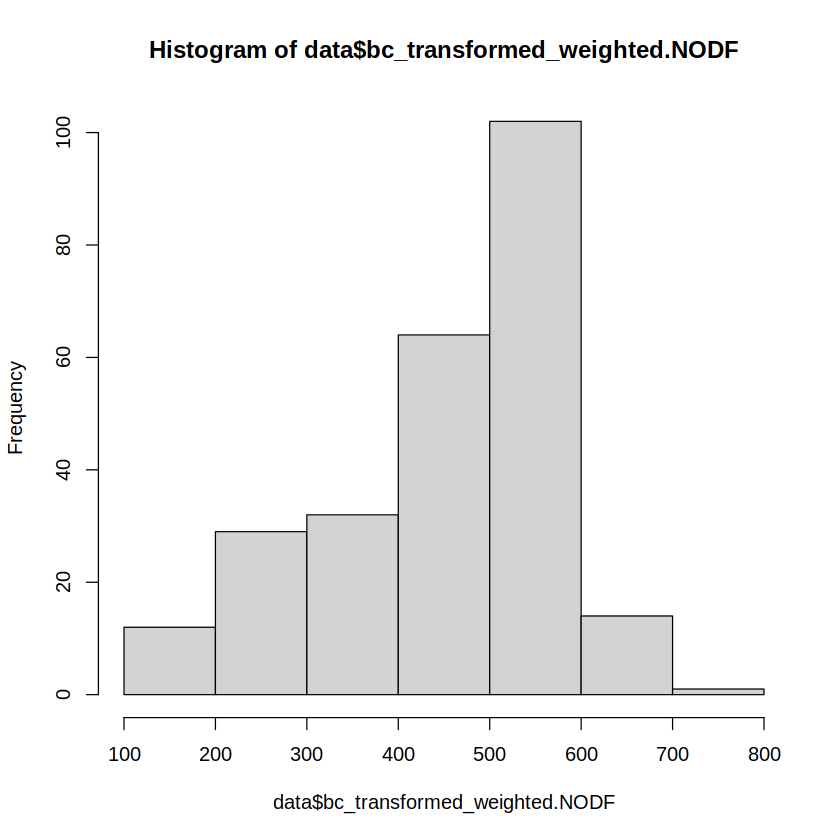

In [164]:
hist(data$bc_transformed_weighted.NODF)

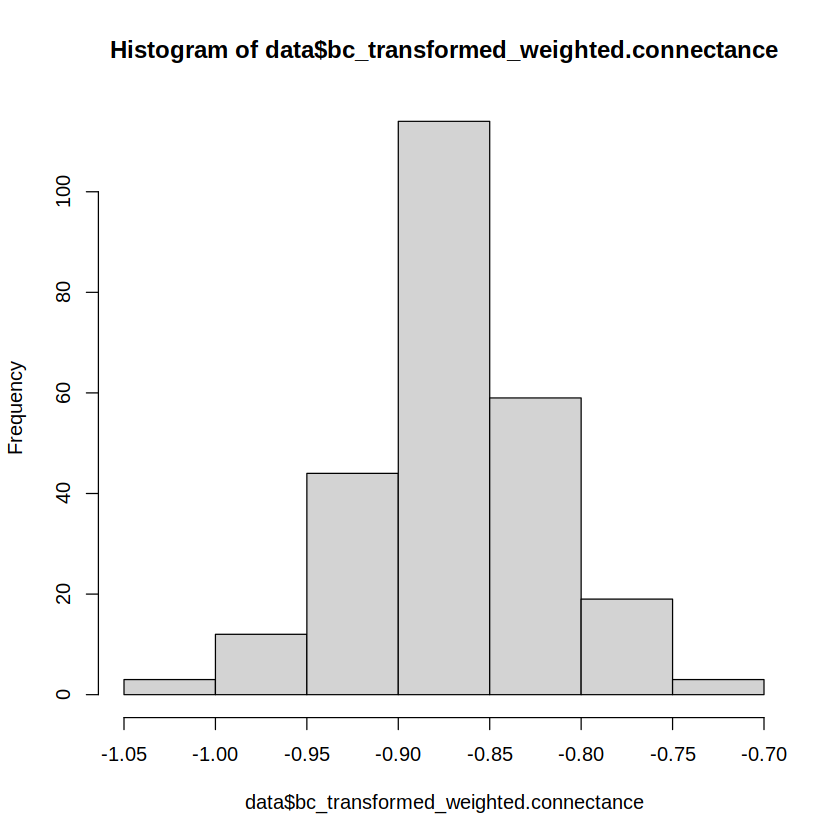

In [165]:
hist(data$bc_transformed_weighted.connectance)

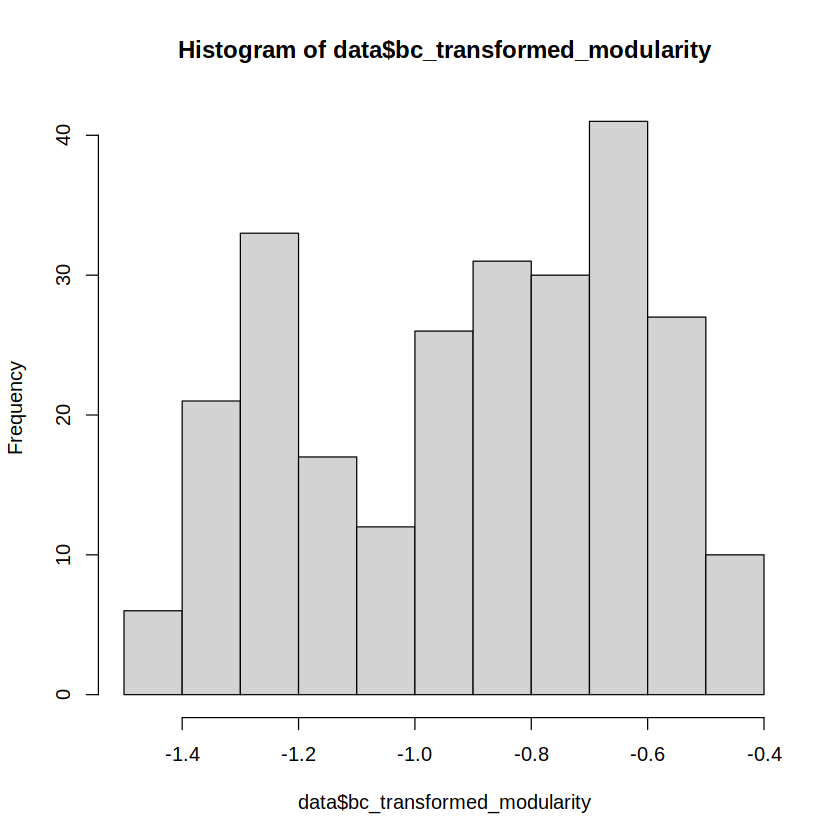

In [166]:
hist(data$bc_transformed_modularity)

# nestedness

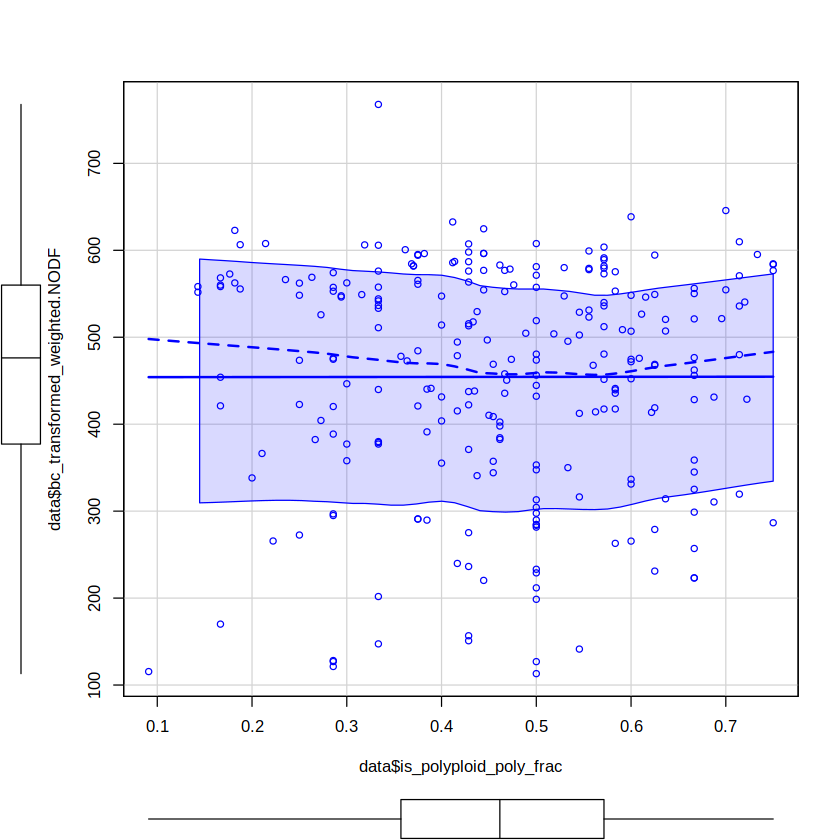

In [167]:
scatterplot(data$is_polyploid_poly_frac, data$bc_transformed_weighted.NODF)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: complete_formula
   Data: data

REML criterion at convergence: 3042.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1230 -0.5639  0.1567  0.7519  3.0222 

Random effects:
 Groups                        Name        Variance Std.Dev.
 highest_pollinator_rank_index (Intercept)  2884     53.7   
 Residual                                  13478    116.1   
Number of obs: 254, groups:  highest_pollinator_rank_index, 5

Fixed effects:
                                    Estimate Std. Error        df t value
(Intercept)                         715.6546   115.6276  204.3320   6.189
is_polyploid_poly_frac             -167.8693   143.9039  239.7807  -1.167
is_polyploid_missing_frac            -2.4773    75.3708  240.8406  -0.033
pd                                    0.1892     3.9811  241.2283   0.048
network_size                       -232.8399    88.7681  240.4405  -2.623
Climate_PC1

Warning message in anova.lm(lm(resp ~ group)):
“ANOVA F-tests on an essentially perfect fit are unreliable”


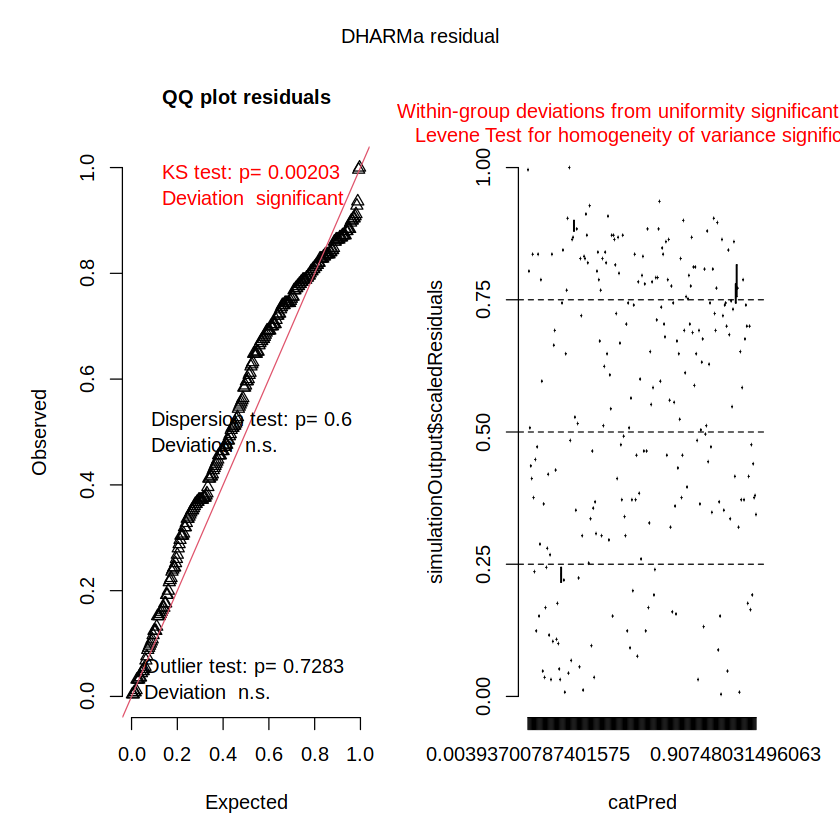

In [203]:
nest_res_df = test_ploidy_freq_effect("bc_transformed_weighted.NODF", covars=c("Climate_PC1", "Climate_PC2", "Climate_PC3"))#, "Species.richness", 'Perennial.herb..', "Polyploid.percent"))

In [204]:
round_df(nest_res_df)

,Estimate,Std..Error,df,t.value,Pr...t..,response_varaible
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),715.65457,115.62758,204.3320,6.18931,0.00000,bc_transformed_weighted.NODF
is_polyploid_poly_frac,-167.86933,143.90391,239.7808,-1.16654,0.24456,bc_transformed_weighted.NODF
is_polyploid_missing_frac,-2.47732,75.37080,240.8406,-0.03287,0.97381,bc_transformed_weighted.NODF
pd,0.18922,3.98107,241.2283,0.04753,0.96213,bc_transformed_weighted.NODF
network_size,-232.83989,88.76814,240.4405,-2.62301,0.00927,bc_transformed_weighted.NODF
Climate_PC1,17.79614,18.21645,240.3014,0.97693,0.32959,bc_transformed_weighted.NODF
Climate_PC2,-24.47842,15.76557,241.1318,-1.55265,0.12182,bc_transformed_weighted.NODF
Climate_PC3,-79.26021,50.69368,239.1603,-1.56351,0.11925,bc_transformed_weighted.NODF
is_polyploid_poly_frac:Climate_PC1,-12.60382,33.54999,239.1155,-0.37567,0.70749,bc_transformed_weighted.NODF


# connectance

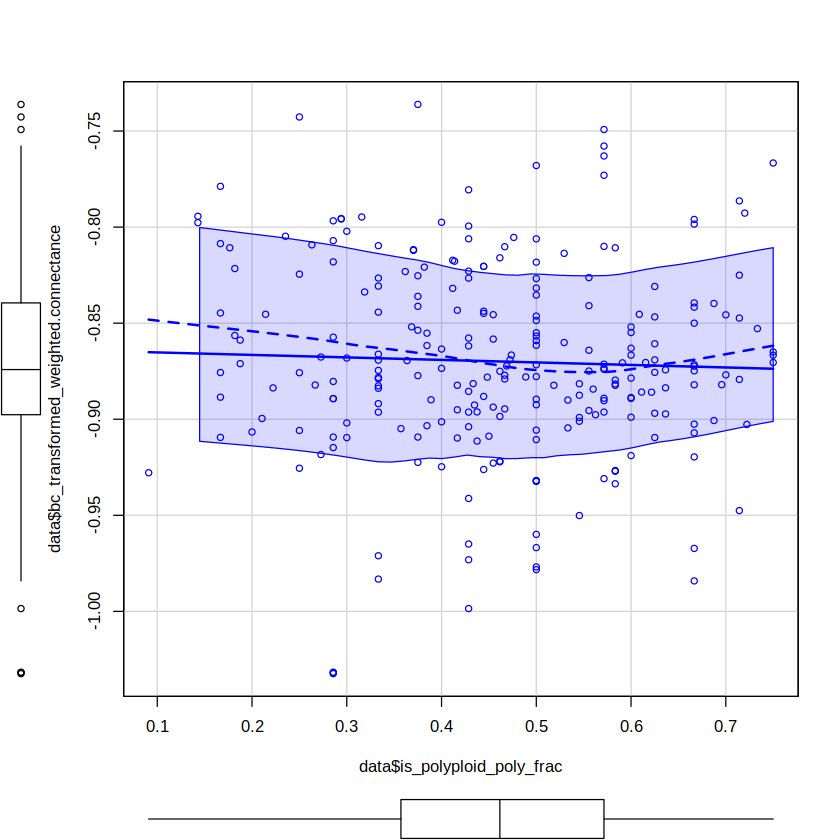

In [205]:
scatterplot(data$is_polyploid_poly_frac, data$bc_transformed_weighted.connectance)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: complete_formula
   Data: data

REML criterion at convergence: -763.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7890 -0.5972 -0.0871  0.6186  2.6659 

Random effects:
 Groups                        Name        Variance  Std.Dev.
 highest_pollinator_rank_index (Intercept) 9.493e-05 0.009743
 Residual                                  2.149e-03 0.046363
Number of obs: 254, groups:  highest_pollinator_rank_index, 5

Fixed effects:
                                     Estimate Std. Error         df t value
(Intercept)                         -0.798307   0.045080 233.472739 -17.709
is_polyploid_poly_frac              -0.143063   0.057371 241.965928  -2.494
is_polyploid_missing_frac           -0.063341   0.029435 199.867287  -2.152
pd                                   0.004817   0.001583 242.947698   3.042
network_size                        -0.048219   0.035363 242.198597  -1.

Warning message in anova.lm(lm(resp ~ group)):
“ANOVA F-tests on an essentially perfect fit are unreliable”


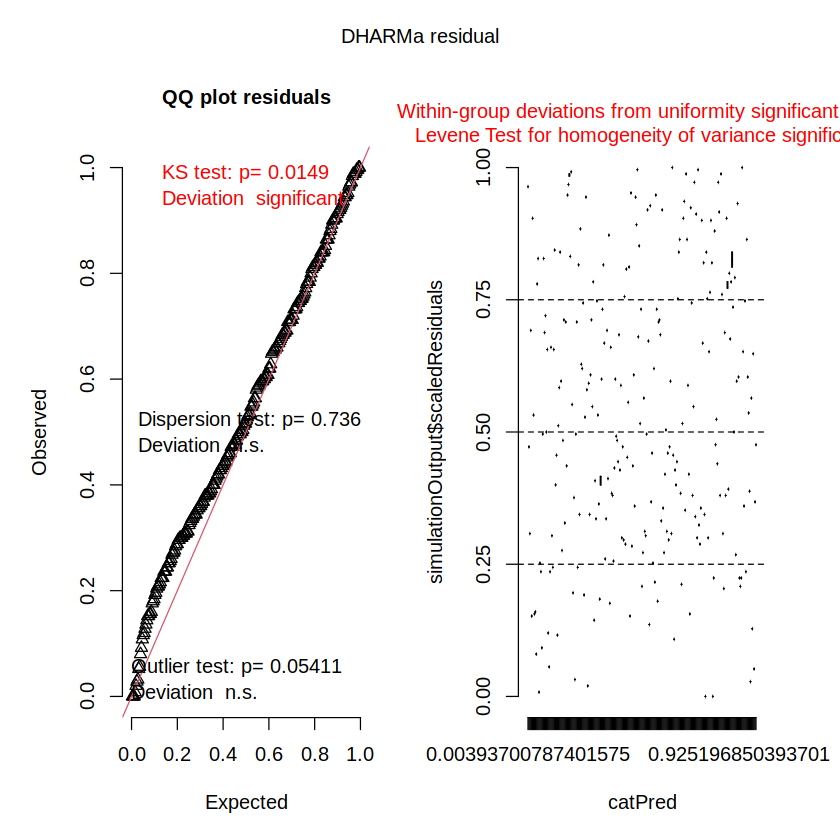

In [206]:
cont_res_df = test_ploidy_freq_effect("bc_transformed_weighted.connectance", covars=c("Climate_PC1", "Climate_PC2", "Climate_PC3"))#, "Species.richness", 'Perennial.herb..', "Polyploid.percent"))

In [207]:
round_df(cont_res_df)

,Estimate,Std..Error,df,t.value,Pr...t..,response_varaible
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-0.79831,0.04508,233.4727,-17.70877,0.00000,bc_transformed_weighted.connectance
is_polyploid_poly_frac,-0.14306,0.05737,241.9659,-2.49363,0.01331,bc_transformed_weighted.connectance
is_polyploid_missing_frac,-0.06334,0.02943,199.8673,-2.15190,0.03260,bc_transformed_weighted.connectance
pd,0.00482,0.00158,242.9477,3.04217,0.00261,bc_transformed_weighted.connectance
network_size,-0.04822,0.03536,242.1986,-1.36352,0.17398,bc_transformed_weighted.connectance
Climate_PC1,-0.00623,0.00726,242.3909,-0.85905,0.39116,bc_transformed_weighted.connectance
Climate_PC2,-0.00517,0.00627,242.6875,-0.82335,0.41112,bc_transformed_weighted.connectance
Climate_PC3,-0.02763,0.02023,241.3404,-1.36582,0.17327,bc_transformed_weighted.connectance
is_polyploid_poly_frac:Climate_PC1,0.02004,0.01339,241.1504,1.49699,0.13570,bc_transformed_weighted.connectance


# modularity

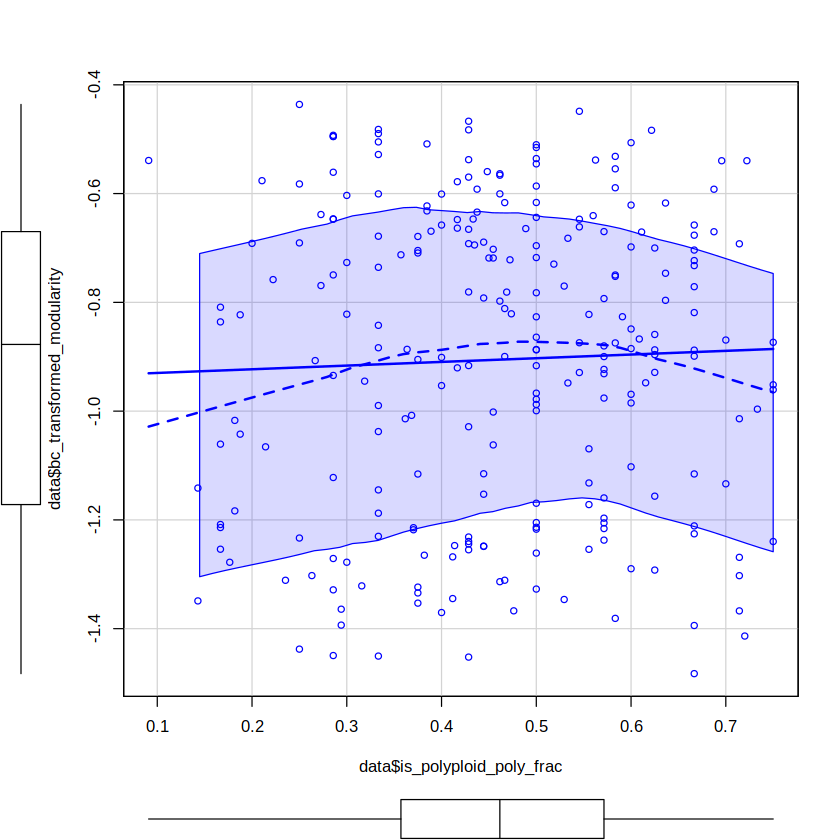

In [208]:
scatterplot(data$is_polyploid_poly_frac, data$bc_transformed_modularity)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: complete_formula
   Data: data

REML criterion at convergence: 81.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.09678 -0.88305  0.04588  0.78763  2.18036 

Random effects:
 Groups                        Name        Variance Std.Dev.
 highest_pollinator_rank_index (Intercept) 0.002121 0.04606 
 Residual                                  0.069905 0.26440 
Number of obs: 254, groups:  highest_pollinator_rank_index, 5

Fixed effects:
                                     Estimate Std. Error         df t value
(Intercept)                         -1.133513   0.256271 231.436118  -4.423
is_polyploid_poly_frac               0.983724   0.327045 242.060537   3.008
is_polyploid_missing_frac            0.276796   0.166768 170.942472   1.660
pd                                  -0.027679   0.009021 242.999987  -3.068
network_size                         0.063775   0.201576 242.165738

Warning message in anova.lm(lm(resp ~ group)):
“ANOVA F-tests on an essentially perfect fit are unreliable”


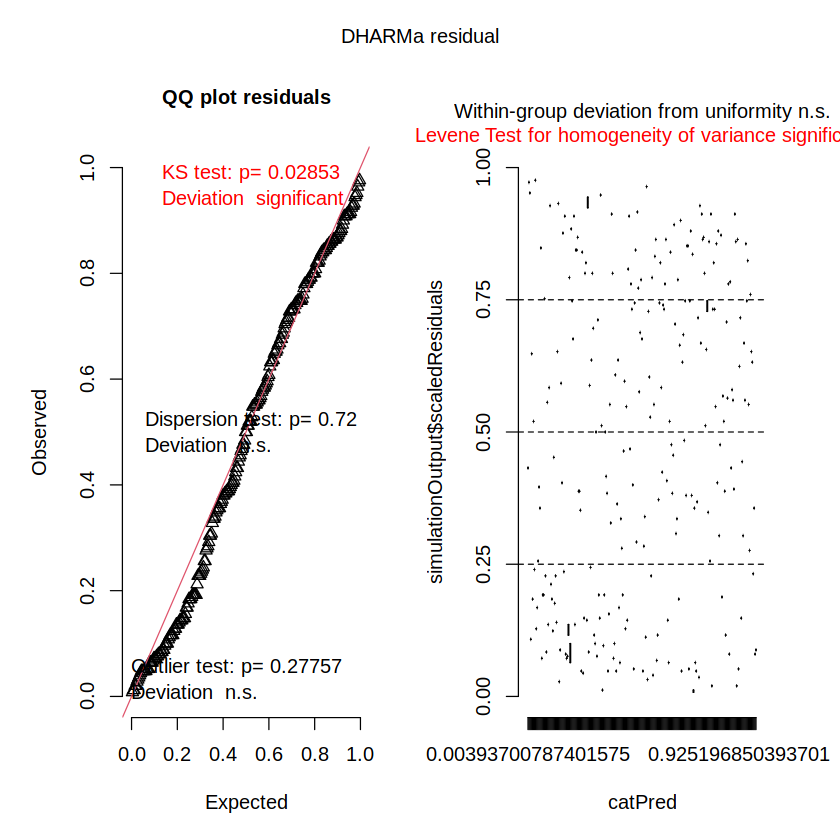

In [210]:
modul_res_df = test_ploidy_freq_effect("bc_transformed_modularity", covars=c("Climate_PC1", "Climate_PC2", "Climate_PC3"))#, "Species.richness", 'Perennial.herb..', "Polyploid.percent"))

In [211]:
round_df(modul_res_df)

,Estimate,Std..Error,df,t.value,Pr...t..,response_varaible
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-1.13351,0.25627,231.4361,-4.42310,0.00001,bc_transformed_modularity
is_polyploid_poly_frac,0.98372,0.32704,242.0605,3.00792,0.00291,bc_transformed_modularity
is_polyploid_missing_frac,0.27680,0.16677,170.9425,1.65977,0.09879,bc_transformed_modularity
pd,-0.02768,0.00902,243.0000,-3.06829,0.00240,bc_transformed_modularity
network_size,0.06377,0.20158,242.1657,0.31638,0.75199,bc_transformed_modularity
Climate_PC1,0.00980,0.04136,242.5041,0.23696,0.81289,bc_transformed_modularity
Climate_PC2,0.05283,0.03575,242.7174,1.47760,0.14081,bc_transformed_modularity
Climate_PC3,0.21425,0.11533,241.2795,1.85777,0.06442,bc_transformed_modularity
is_polyploid_poly_frac:Climate_PC1,-0.10807,0.07634,240.9959,-1.41566,0.15817,bc_transformed_modularity


In [212]:
full_df = rbind(rbind(nest_res_df, cont_res_df), modul_res_df)

In [213]:
full_df["significant_by_wald_test"] = full_df$Pr...t.. <= 0.05

In [214]:
write.csv(full_df, res_path)

In [215]:
round_df(drop_na(full_df[full_df$significant_by_wald_test,]))

,Estimate,Std..Error,df,t.value,Pr...t..,response_varaible,significant_by_wald_test
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
(Intercept),715.65457,115.62758,204.3320,6.18931,0.00000,bc_transformed_weighted.NODF,TRUE
network_size,-232.83989,88.76814,240.4405,-2.62301,0.00927,bc_transformed_weighted.NODF,TRUE
is_polyploid_poly_frac:Climate_PC2,97.80321,36.23441,239.3767,2.69918,0.00745,bc_transformed_weighted.NODF,TRUE
(Intercept)1,-0.79831,0.04508,233.4727,-17.70877,0.00000,bc_transformed_weighted.connectance,TRUE
is_polyploid_poly_frac1,-0.14306,0.05737,241.9659,-2.49363,0.01331,bc_transformed_weighted.connectance,TRUE
is_polyploid_missing_frac1,-0.06334,0.02943,199.8673,-2.15190,0.03260,bc_transformed_weighted.connectance,TRUE
pd1,0.00482,0.00158,242.9477,3.04217,0.00261,bc_transformed_weighted.connectance,TRUE
is_polyploid_poly_frac:Climate_PC21,0.03220,0.01445,241.8674,2.22798,0.02680,bc_transformed_weighted.connectance,TRUE
(Intercept)2,-1.13351,0.25627,231.4361,-4.42310,0.00001,bc_transformed_modularity,TRUE
